In [1]:
from segment_anything import sam_model_registry
from segment_anything.utils.transforms import ResizeLongestSide
import nibabel as nib
import torch
import numpy as np
import matplotlib.pyplot as plt
from monai.losses import DiceLoss, FocalLoss, GeneralizedDiceFocalLoss, DiceCELoss
import utils.visualize_kits as vis
from utils.create_prompt import identify_box
import cv2
import torch.nn.functional as F
from torchvision import transforms

In [435]:
case_id = "case_00012"
seg = nib.load(f"./kits23/dataset/{case_id}/segmentation.nii.gz").get_fdata()
image = cv2.convertScaleAbs(nib.load(f"./kits23/dataset/{case_id}/imaging.nii.gz").get_fdata())
image_rgb = np.apply_along_axis(lambda x: cv2.cvtColor(x, cv2.COLOR_GRAY2RGB), axis=0, arr=image).squeeze(axis=1)
embedding = np.load(f"./kits23/dataset/{case_id}/embedding.npz")["embeddings"]

In [436]:
inds = np.load(f"./kits23/dataset/{case_id}/embedding.npz")["indices"]
# seg = np.clip(seg, None, 1)
inds

array([ 1,  3,  5,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
       23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,
       41, 43, 44, 46, 47, 48, 49, 53, 57, 58, 59, 60, 66, 71, 72, 73, 74,
       75, 76, 77, 78, 80, 81, 87])

In [198]:
np.load(f"./kits23/dataset/{case_id}/embedding.npz")["is_blank"]

array([ True,  True,  True,  True,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

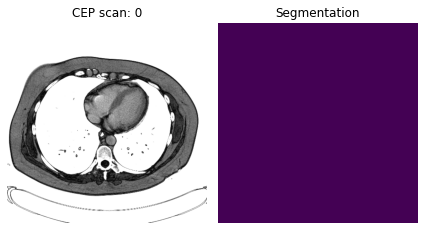

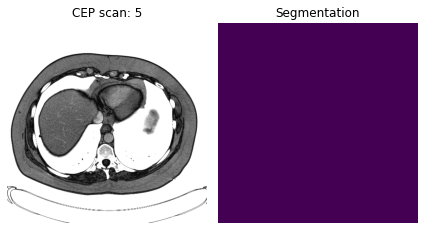

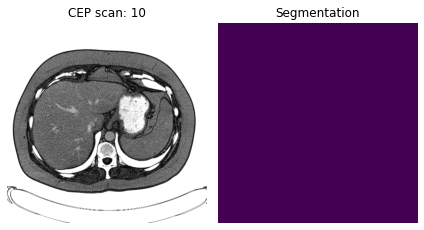

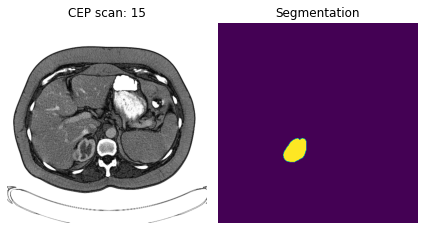

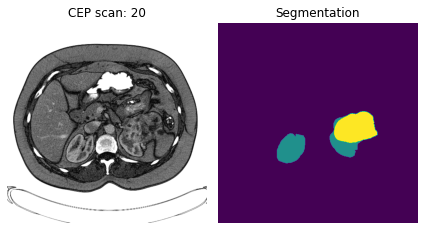

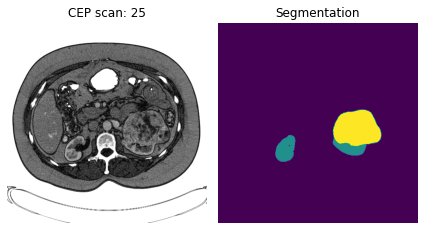

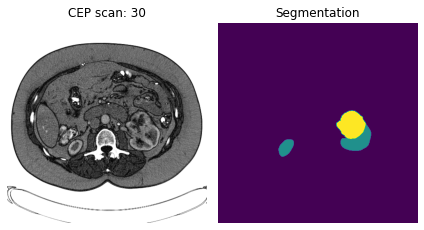

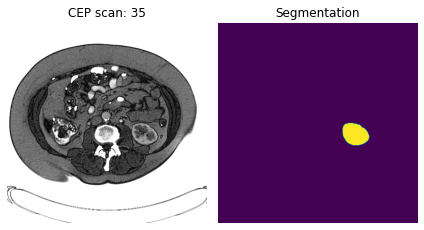

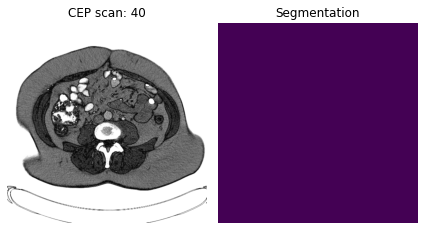

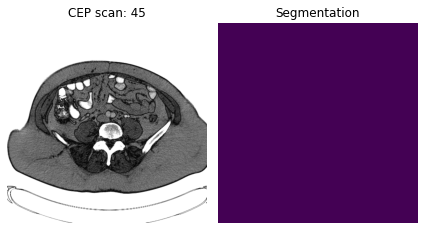

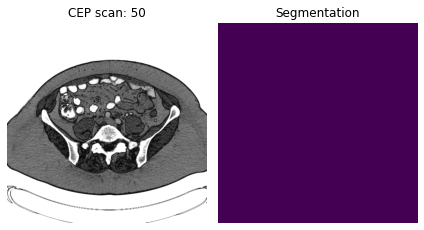

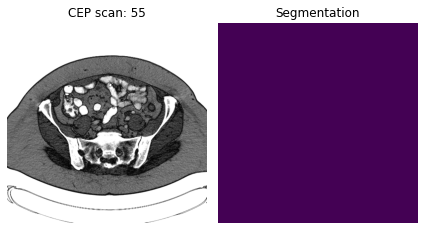

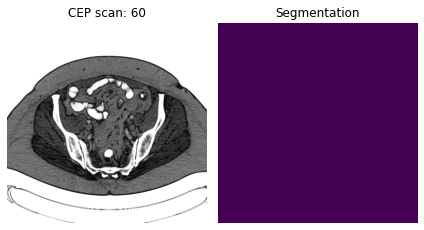

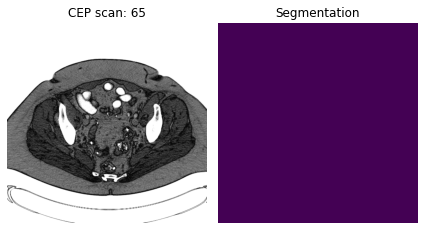

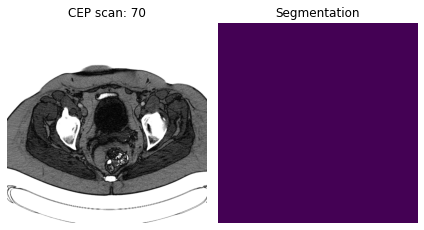

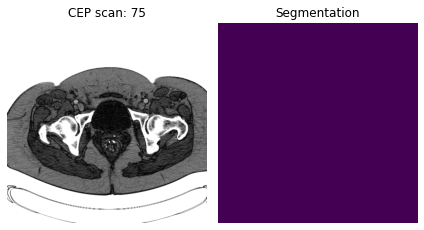

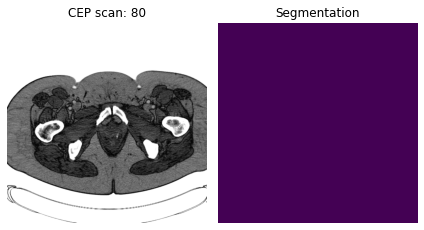

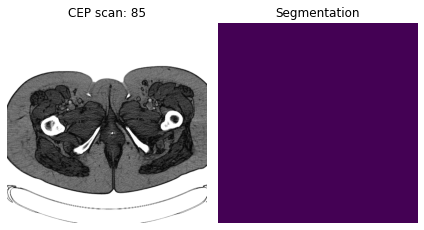

In [437]:
vis.visualize3d_scan(image_rgb, seg, 5)

In [276]:
# sam_base = sam_model_registry["vit_b"]("./models/sam_vit_b_01ec64.pth")
# sam_base = sam_model_registry["vit_b"]()
sam_base = sam_model_registry["vit_b"]("./models/kidney/checkpoint_0_800.pth")
# trained_model = sam_model_registry["vit_b"]("./models/checkpoint_0_300.pth")
# Transform to reshape into 1024x1024 resolution model needs
sam_transform = ResizeLongestSide(sam_base.image_encoder.img_size)

In [687]:
state_dict_encoder= {}
with open("./models/sam_vit_b_01ec64.pth", "rb") as f:
    state_dict = torch.load(f, map_location=torch.device("cpu"))

[state_dict_encoder.update({k[15:]:v}) for k, v in state_dict.items() if k.startswith("prompt_encoder")]
sam_base.prompt_encoder.load_state_dict(state_dict_encoder, strict=True)

<All keys matched successfully>

In [287]:
def monitor_grads(params):
    plt.figure(figsize=(15, 15))
    layers, norms, maxs, mins, means = [], [], [], [], []
    for name, param in params:
        if (param.requires_grad and param.grad is not None) and ("bias" not in name):
            layers.append(name)
            norms.append(torch.linalg.norm(param.grad.cpu()).item())
            maxs.append(param.grad.cpu().max().item())
            mins.append(param.grad.cpu().min().item())
            means.append(param.grad.cpu().mean().item())
    plt.plot(layers, norms, alpha=0.3, color="blue")
    plt.plot(layers, maxs, alpha=0.3, color="green")
    plt.plot(layers, mins, alpha=0.3, color="red")
    plt.plot(layers, means, alpha=0.3, color="orange")

    plt.xlim(xmin=0, xmax=len(layers))
    plt.xticks(rotation=90)
    plt.xlabel("Layers")
    plt.title("Monitoring gradient L2-norm")
    plt.ylabel("L2 Norm")
    plt.grid(True)

In [6]:
optimizer = torch.optim.AdamW(params=sam_base.mask_decoder.parameters(), lr=0.00001, betas=(0.9, 0.999), weight_decay=0.1)


In [14]:
# Eval
loss_ce = torch.nn.BCEWithLogitsLoss()
dice_loss = DiceLoss(reduction='mean', softmax=True, to_onehot_y=True, squared_pred=True)
loss_mce = torch.nn.CrossEntropyLoss()


In [13]:
loss_ce = torch.nn.BCEWithLogitsLoss()

In [15]:
dice_loss_basic = DiceLoss(reduction='mean', softmax=True, to_onehot_y=True)

In [913]:
dice_loss = GeneralizedDiceFocalLoss(to_onehot_y=True, gamma=2, softmax=True, focal_weight=torch.tensor([0.0000001, 1, 1, 20]))

In [81]:
dice_loss = FocalLoss(to_onehot_y=True, gamma=2, use_softmax=True)

In [58]:
dice_loss = DiceCELoss(to_onehot_y=True, softmax=True, ce_weight=torch.tensor([1.0, 1., 1, 1]))

In [315]:
dice_loss = DiceCELoss(sigmoid=True, squared_pred=True)

In [10]:
def train(model, id, n_batch):
    losses = []
    for i in range(n_batch):
        np.random.seed(42)
        # Prediction
        id = id
        embed_id = np.where(inds == id)[0]
        box = identify_box(seg[id][None, : ], prob=0.2)
        box_reshaped = sam_transform.apply_boxes(
            box,
            original_size=(512, 512)
        )
        sparse_embeddings, dense_embeddings = model.prompt_encoder(
            points=None,
            boxes=torch.as_tensor(box_reshaped), # Bx4
            masks=None
        )
        masks, _ = model.mask_decoder(
            image_embeddings=torch.as_tensor(embedding[embed_id]), # Bx256x64x64
            image_pe=model.prompt_encoder.get_dense_pe(), # 1x256x64x64
            sparse_prompt_embeddings=sparse_embeddings, # Bx2x256
            dense_prompt_embeddings=dense_embeddings, # Bx256x64x64
            multimask_output=True
        )
        mask_pred = model.postprocess_masks(
            masks,
            input_size=(1024, 1024),
            original_size=(512, 512)
        )
        # loss = dice_loss(mask_pred, torch.as_tensor(seg[id].clip(max=2)[None, None, :, :], dtype=torch.long))
        loss = dice_loss(mask_pred, torch.as_tensor(seg[id][None, None, :, :], dtype=torch.long))
        print(f"Loss equals: {loss}")
        if loss==0: break
        losses.append(loss)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    return model, losses
    

In [40]:
sam_base, result = train(sam_base, 120, 30)

Loss equals: 0.0004088518617209047
Loss equals: 0.00040512834675610065
Loss equals: 0.0004015524173155427
Loss equals: 0.0003979800676461309
Loss equals: 0.00039433164056390524
Loss equals: 0.0003906120837200433
Loss equals: 0.0003868917701765895
Loss equals: 0.0003832660731859505
Loss equals: 0.00037980827619321644
Loss equals: 0.00037654326297342777
Loss equals: 0.0003734454221557826
Loss equals: 0.0003704557311721146
Loss equals: 0.0003675119369290769
Loss equals: 0.0003645703836809844
Loss equals: 0.0003616195172071457
Loss equals: 0.00035867735277861357
Loss equals: 0.0003557781456038356
Loss equals: 0.00035295539419166744
Loss equals: 0.00035022664815187454
Loss equals: 0.00034758992842398584
Loss equals: 0.00034502591006457806
Loss equals: 0.000342508836183697
Loss equals: 0.00034001836320385337
Loss equals: 0.0003375450614839792
Loss equals: 0.00033509309287182987
Loss equals: 0.0003326744772493839
Loss equals: 0.0003303021949250251
Loss equals: 0.0003279833763372153
Loss equal

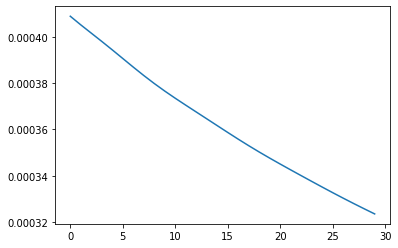

In [41]:
plt.plot(range(30), [l.detach() for l in result])

In [495]:
# Prediction
np.random.seed(42)
id = 30
embed_id = np.where(inds == id)[0]
box = identify_box(seg, prob=0.2)[id]
box_reshaped = sam_transform.apply_boxes(
    box,
    original_size=(512, 512)
)

sparse_embeddings, dense_embeddings = sam_base.prompt_encoder(
    points=None,
    boxes=torch.as_tensor(box_reshaped), # Bx4
    masks=None
)
masks, _ = sam_base.mask_decoder(
    image_embeddings=torch.as_tensor(embedding[embed_id]), # Bx256x64x64
    image_pe=sam_base.prompt_encoder.get_dense_pe(), # 1x256x64x64
    sparse_prompt_embeddings=sparse_embeddings, # Bx2x256
    dense_prompt_embeddings=dense_embeddings, # Bx256x64x64
    multimask_output=False
)
# masks_trained, _ = trained_model.mask_decoder(
#     image_embeddings=torch.as_tensor(embedding[embed_id]), # Bx256x64x64
#     image_pe=trained_model.prompt_encoder.get_dense_pe(), # 1x256x64x64
#     sparse_prompt_embeddings=sparse_embeddings, # Bx2x256
#     dense_prompt_embeddings=dense_embeddings, # Bx256x64x64
#     multimask_output=True
# )
mask_pred = sam_base.postprocess_masks(
    masks,
    input_size=(1024, 1024),
    original_size=(512, 512)
)
# mask_trained_pred = trained_model.postprocess_masks(
#     masks_trained,
#     input_size=(1024, 1024),
#     original_size=(512, 512)
# )


#loss_crosse = loss_ce(mask_trained_pred, torch.as_tensor(gt[ None, :, :, :]))
#loss_crosse
# loss_crosse = loss_ce(mask_pred, torch.as_tensor(seg[id][None, None, :, :]))
# loss_trained_crosse = loss_ce(mask_trained_pred, torch.as_tensor(seg[id][None, None, :, :]))
#print(f"Loss_base: {loss_crosse}\nLoss_trained: {loss_trained_crosse}")

In [439]:
loss = dice_loss(mask_pred, torch.as_tensor(seg[id][None, None, :, :], dtype=torch.long))
loss_2 = loss_mce(mask_pred, torch.as_tensor(seg[id][None, :, :], dtype=torch.long))
loss_basic = dice_loss_basic(mask_pred, torch.as_tensor(seg[id][None, None, :, :], dtype=torch.long))

loss, loss_2, loss_basic

IndexError: Target 2 is out of bounds.

In [499]:
loss = dice_loss(mask_pred, torch.as_tensor(seg[id][None, None, :, :], dtype=torch.long).clip(max=1))
loss

tensor(0.2901, grad_fn=<AddBackward0>)

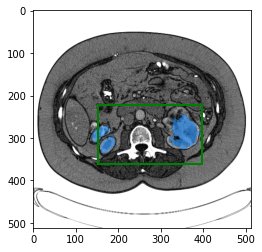

In [496]:
# Visual
plt.imshow(image_rgb[id].transpose(1, 2, 0))
vis.show_box(box, plt.gca())
#vis.show_mask(torch.sigmoid(mask_trained_pred.squeeze()[1].detach()), plt.gca())
#vis.show_mask(F.softmax(mask_pred, dim=1)[0][0].detach(), plt.gca())
# vis.show_mask(mask_pred.detach()[0][0] > 0, plt.gca())
vis.show_mask(torch.sigmoid(mask_pred[0].detach()), plt.gca())
#vis.show_mask(gt[1] * 20, plt.gca())
#vis.show_mask(torch.sigmoid(mask_pred.squeeze().detach()), plt.gca())


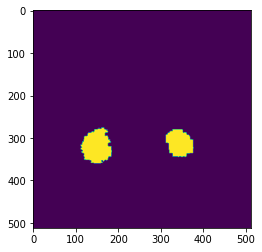

In [341]:
plt.imshow(torch.sigmoid(mask_pred[0].detach())[0] > 0)

In [328]:
torch.sigmoid(mask_pred[0].detach())[0].unique()

tensor([0.0000e+00, 3.0074e-39, 3.0384e-39,  ..., 5.8333e-04, 4.0833e-03,
        9.6286e-03])

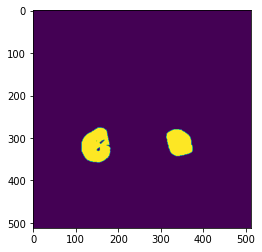

In [343]:
plt.imshow(seg[id] == 1)

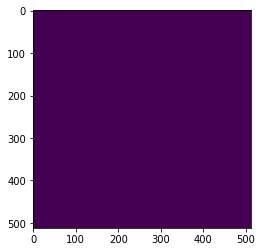

In [314]:
probs = F.softmax(mask_pred, dim=1).detach()
scores, label_prediction = torch.max(probs, dim=1)
label_prediction[scores < 0] = 0
plt.imshow(label_prediction[0] == 1)

In [419]:
sam_model = sam_model_registry["vit_b"]("./models/sam_vit_b_01ec64.pth")

In [483]:
np.random.seed(42)
id = 30
embed_id = np.where(inds == id)[0]
box = identify_box(seg, prob=0.2)[id]
box_reshaped = sam_transform.apply_boxes(
    box,
    original_size=(512, 512)
)

sparse_embeddings, dense_embeddings = sam_base.prompt_encoder(
    points=None,
    boxes=torch.as_tensor(box_reshaped), # Bx4
    masks=None
)
masks, quality = sam_model.mask_decoder(
    image_embeddings=torch.as_tensor(embedding[embed_id]), # Bx256x64x64
    image_pe=sam_model.prompt_encoder.get_dense_pe(), # 1x256x64x64
    sparse_prompt_embeddings=sparse_embeddings, # Bx2x256
    dense_prompt_embeddings=dense_embeddings, # Bx256x64x64
    multimask_output=False
)
mask_pred = sam_base.postprocess_masks(
    masks,
    input_size=(1024, 1024),
    original_size=(512, 512)
)

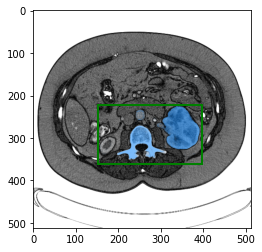

In [485]:
# Visual
plt.imshow(image_rgb[id].transpose(1, 2, 0))
vis.show_box(box, plt.gca())
vis.show_mask(torch.sigmoid(mask_pred[0].detach()), plt.gca())


In [507]:
masks.shape

torch.Size([1, 1, 256, 256])

In [534]:
transform_test = ResizeLongestSide(target_length=256)
seg_reshaped = transform_test.apply_image(seg[id].astype("uint8"))

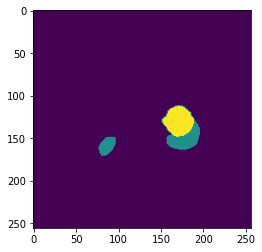

In [548]:
plt.imshow(seg_reshaped)

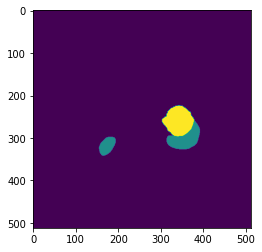

In [549]:
plt.imshow(seg[id])

In [536]:
seg_reshaped.dtype

dtype('uint8')

In [547]:
# Testiong mask prompts
sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
    points=None,
    boxes=torch.as_tensor(box_reshaped),
    masks=torch.as_tensor(seg_reshaped[None, None, :, :], dtype=torch.float32)
)
masks_2, quality = sam_model.mask_decoder(
    image_embeddings=torch.as_tensor(embedding[embed_id]), # Bx256x64x64
    image_pe=sam_model.prompt_encoder.get_dense_pe(), # 1x256x64x64
    sparse_prompt_embeddings=sparse_embeddings, # Bx2x256
    dense_prompt_embeddings=dense_embeddings, # Bx256x64x64
    multimask_output=True
)
mask_pred_2 = sam_model.postprocess_masks(
    masks_2,
    input_size=(1024, 1024),
    original_size=(512, 512)
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


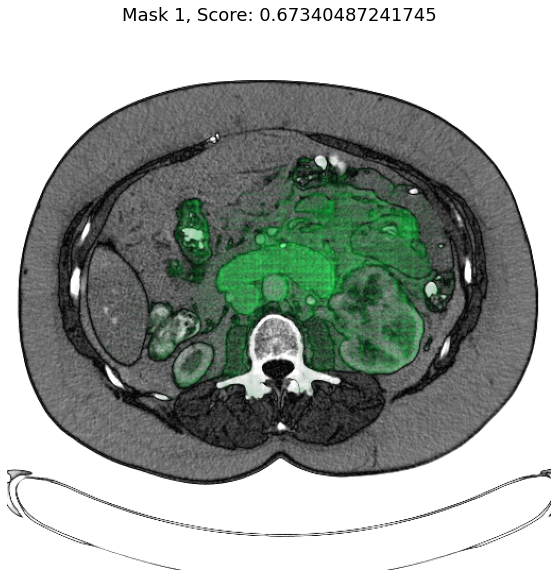

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


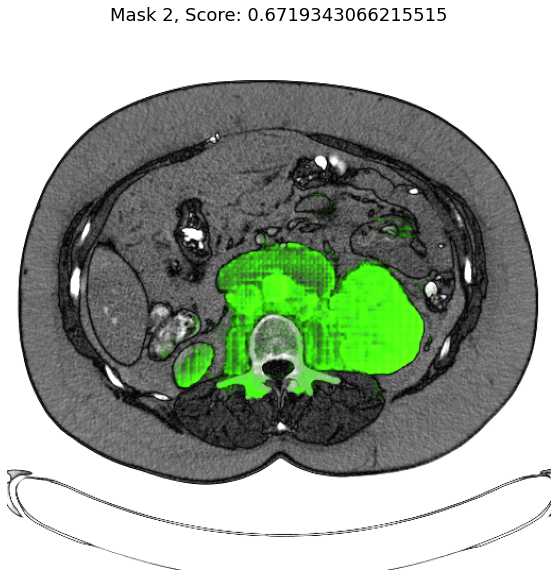

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


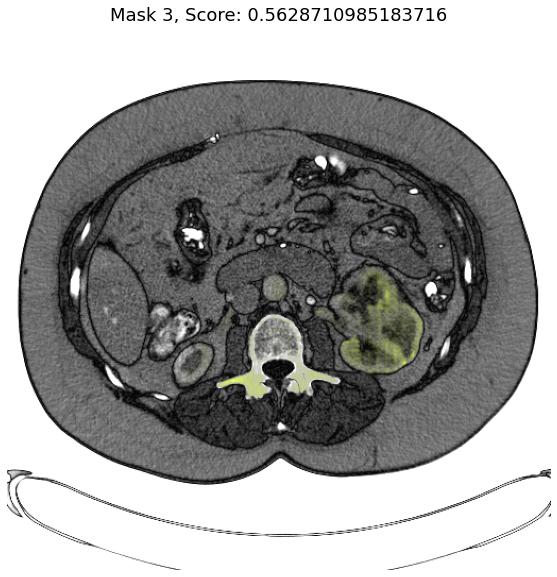

In [546]:
for i, (mask, score) in enumerate(zip(mask_pred_2[0], quality[0])):
    plt.figure(figsize=(10,10))
    plt.imshow(image_rgb[id].transpose(1, 2, 0))
    vis.show_mask(mask.detach(), plt.gca(), random_color=True)
    plt.title(f"Mask {i+1}, Score: {score.detach()}", fontsize=18)
    plt.axis('off')
    plt.show() 

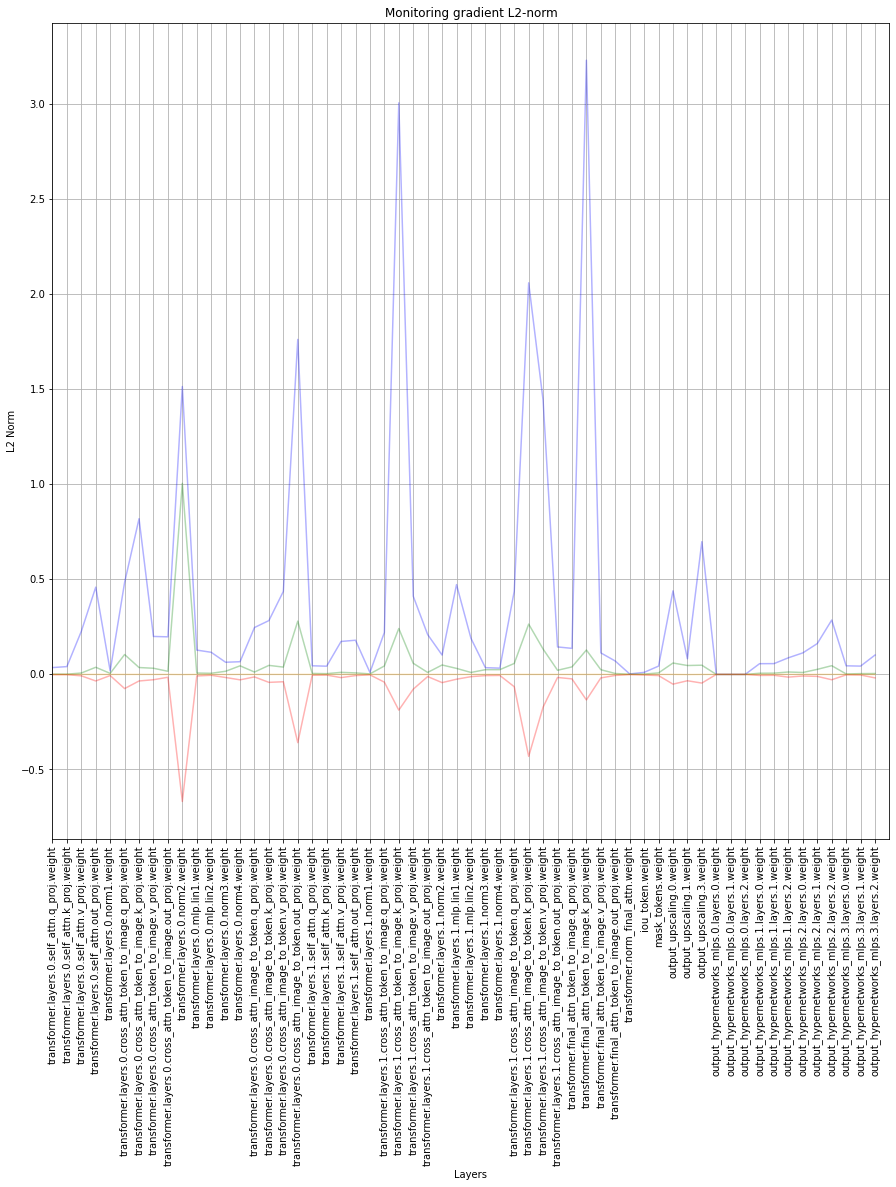

In [1672]:
monitor_grads(sam_base.mask_decoder.named_parameters())
optimizer.zero_grad()


In [155]:
image_outlier = cv2.convertScaleAbs(nib.load("./outliers/case_00425/imaging.nii.gz").get_fdata())
seg = cv2.convertScaleAbs(nib.load("./outliers/case_00425//segmentation.nii.gz").get_fdata())
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])
images_resied = torch.vstack([transform(img) for img in image_outlier])
seg_resized = torch.vstack([transform(se) for se in seg])
image_resized_rgb = np.apply_along_axis(lambda x: cv2.cvtColor(x, cv2.COLOR_GRAY2RGB), axis=0, arr=images_resied).squeeze(axis=1)

NameError: name 'dice_loss' is not defined

In [81]:
import yaml
import math
optimizer = torch.optim.AdamW(params=sam_base.mask_decoder.parameters(), lr=0.00001, betas=(0.9, 0.999), weight_decay=0.1)
# Read the YAML file
with open('config.yaml', 'r') as file:
    config = yaml.safe_load(file)
data_config = config["data_config"]
training_config = config["training_config"]
optimizer_config = config["optimizer_config"]
lr_schedule = config["lr_schedule"]

In [64]:
lr_schedule

{True: {'constant_lr': 200,
  'min_lr': 1e-08,
  'cosine_annealing_T_0': 30,
  'cosine_annealing_T_mult': 2}}

In [82]:
def cosine_annealing_with_wave(batch, num_batches, interval, max_lr, min_lr):
    wave_height = max_lr - ((batch // interval) * (max_lr - min_lr) / (num_batches // interval))
    wave_length = num_batches // interval
    wave_value = (math.cos(math.pi * (batch % wave_length) / wave_length) + 1) / 2 * wave_height + min_lr
    return wave_value

def generate_lr_shedule(config: dict):
    for key, value in config.items():
        if key:
            constant_n = value["constant_lr"]
            lr_init = optimizer.param_groups[0]["lr"]
            # Total number of batches
            n_batches = 800
            lrs =  []
            
            for epoch in range(training_config['n_epoch']):
                # Constant part
                lrs.extend(constant_n * [lr_init / (epoch + 1)])
                # Cosine part
                for batch in range(n_batches - constant_n):
                    lr = cosine_annealing_with_wave(
                        batch,
                        n_batches - constant_n,
                        max(int((n_batches - constant_n) / 100), 1),
                        lr_init / (epoch + 1), 
                        value["min_lr"]
                    )
                    lrs.append(lr)
            return lrs

In [83]:
lrs = generate_lr_shedule(lr_schedule)
lrs

[1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,
 1e-05,


Text(0.5, 1.0, 'Learning Rate Schedule')

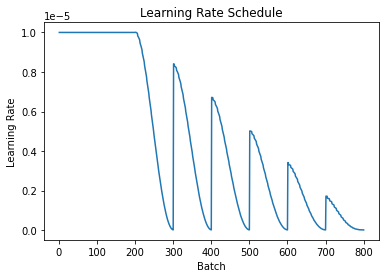

In [85]:
plt.plot(range(1, len(lrs) + 1), lrs)
plt.xlabel('Batch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')

In [478]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((512, 512), interpolation=transforms.functional.InterpolationMode.NEAREST),
    transforms.ToTensor()
])

In [479]:
# Resizing
image_outlier = cv2.convertScaleAbs(nib.load("./outliers/case_00425/imaging.nii.gz").get_fdata())
seg_outlier = cv2.convertScaleAbs((nib.load("./outliers/case_00425/segmentation.nii.gz").get_fdata()))

images_resied = torch.vstack([transform(img) for img in image_outlier])
seg_resized = torch.vstack([transform(se) for se in seg_outlier])
image_resized_rgb = np.apply_along_axis(lambda x: cv2.cvtColor(x, cv2.COLOR_GRAY2RGB), axis=0, arr=images_resied).squeeze(axis=1)

In [258]:
plt.imshow((seg_resized * 255).to(torch.uint8)[30])

NameError: name 'seg_resized' is not defined

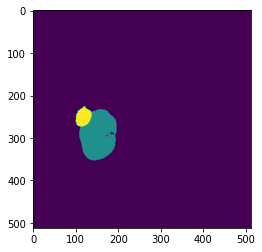

In [474]:
plt.imshow(seg_resized[30])

In [466]:
transforms.ToPILImage(seg_outlier).mode.min()

0

In [260]:
kidney1 = nib.load("./kits23/dataset/case_00063/instances/kidney_instance-1_annotation-1.nii.gz").get_fdata()
kidney2 = nib.load("./kits23/dataset/case_00063/instances/kidney_instance-2_annotation-1.nii.gz").get_fdata()

In [261]:
tumor1 = nib.load("./kits23/dataset/case_00063/instances/tumor_instance-1_annotation-1.nii.gz").get_fdata()
tumor2 = nib.load("./kits23/dataset/case_00063/instances/tumor_instance-2_annotation-1.nii.gz").get_fdata()

In [271]:
cyst1 = nib.load("./kits23/dataset/case_00063/instances/cyst_instance-1_annotation-1.nii.gz").get_fdata()

In [275]:
np.count_nonzero(cyst1 == 1)

6661

In [273]:
np.count_nonzero((kidney2[cyst1 == 1] == 1))

6639